# Рекомендация тарифов

В ходе одного из исследований аналитики компании мобильной связи «Мегалайн» выяснили, что многие клиенты пользуются архивными тарифами. Чтобы повысить рентабельность бизнеса, необходимо перевести клиентов на 2 актуальных тарифа - «Смарт» или «Ультра». Но предлагать клиентам необходимо не просто какой-то тариф, а исходя из их текущего поведения.

**Цель текущего проекта** - построение модели, способную проанализировать поведение клиентов и предложить пользователям новый тариф.

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

**Целевая метрика** - значение на тестовой выборке *accuracy* не ниже 0.75.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

##  Импорт библиотек

In [27]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings("ignore")


## Откройте и изучите файл

### Загрузка данных

In [28]:
df = pd.read_csv('../users_behavior.csv')

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [29]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Изучение статистики по датасету

In [30]:
for dtype in ['float','int','object']:
    selected_dtype = df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

print()
df.info(memory_usage='deep')

Average memory usage for float columns: 0.02 MB
Average memory usage for int columns: 0.01 MB
Average memory usage for object columns: 0.00 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [31]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [32]:
df.duplicated().sum()

0

In [33]:
def get_dataset_short_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для отображения короткой информации по датасету. Аналог функции df.info()

    Args:
        df (pd.DataFrame): Датафрейм с исходным датасетом

    Returns:
        pd.DataFrame: Возвращает датафрейм с описанием данных
    """

    shape = df.shape[0]
    columns = ['column', 'count_values', 'unique_values', '% unique',
               'missing', '% missing', 'dtype']
    rows = []
    for col in df.columns:
        rows.extend([[
            col,  # название столбца
            df[col].count(),  # кол-во НЕ пустых значений
            df[col].nunique(),  # кол-во уникальных значений
            str(round(df[col].nunique() * 100 / df[col].count(), 2)) + '%',
            # доля уникальных значений
            df[col].isna().sum(),  # кол-во пропущенных значений
            str(round((1 - (df[col].count() / shape)), 1) * 100) + '%',
            # доля пропущенных значений
            str(df[col].dtype),  # тип данных
            ]]) 
    info = pd.DataFrame(data=rows, columns=columns).sort_values(
        by=['% missing', 'missing'], ascending=False).round(4)
    return info


get_dataset_short_info(df)

,column,count_values,unique_values,% unique,missing,% missing,dtype
0,calls,3214,184,5.72%,0,0.0%,float64
1,minutes,3214,3144,97.82%,0,0.0%,float64
2,messages,3214,180,5.6%,0,0.0%,float64
3,mb_used,3214,3203,99.66%,0,0.0%,float64
4,is_ultra,3214,2,0.06%,0,0.0%,int64


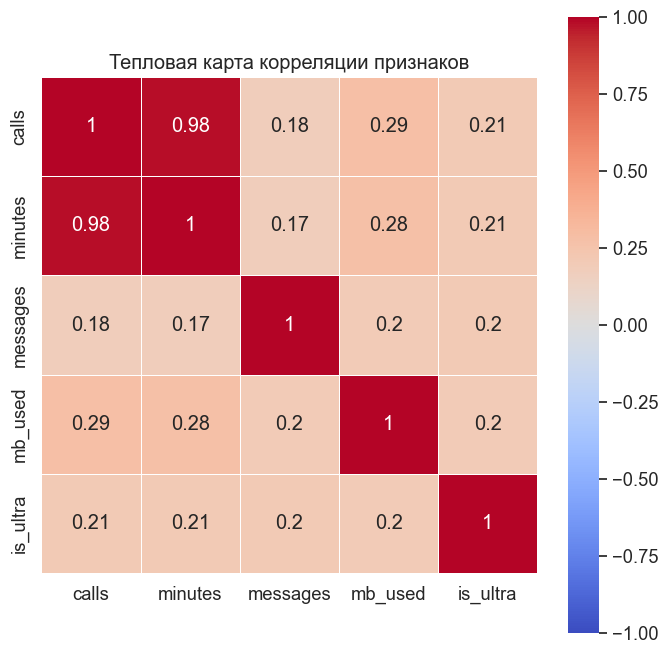

In [34]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,          
    cmap="coolwarm",    
    vmin=-1, vmax=1,     
    square=True,         
    linewidths=0.5,      
)


plt.title("Тепловая карта корреляции признаков")
plt.show()

### Вывод по итогам анализа всей таблицы

Мы оценили количество и струкутуру пропусков в нашем dataframe. Можно отметить, что явных дубликатов мы не имеем, как и пропусков. Увидели, что в нашем df 3214 строк и 5 столбцов. 
Можем отметить, что данные в минутах и использованных mb уникальны. 

Основываясь на предоставленных статистических данных, можно сделать следующие наблюдения:

**calls:** Среднее количество звонков - 63 звонка с стандартным отклонением 33. Количество звонков варьируется от 0 до 244.
Среднее - 63.0, Медиана - 62.0. Среднее значение и медиана очень близки, это может указывать на симметричное распределение данных.

**minutes:** Средняя продолжительность разговоров составляет 438 минут с стандартным отклонением 234 минуты. Продолжительность разговоров варьируется от 0 до 1632 минут.
Среднее - 438.2, Медиана - 430.6. Среднее значение и медиана очень близки, это может указывать на симметричное распределение данных.

**messages:** Среднее количество SMS-сообщений - 38 сообщений со стандартным отклонением 36. Количество сообщений варьируется от 0 до 224.
Среднее - 38.3, Медиана - 30.0.  Среднее значение выше медианы, что указывает на положительную асимметрию (скошенность вправо), что есть пользователи с очень большим количеством отправленных сообщений.


**mb_used:** Средний объем использованных данных составляет 17207 Мб с стандартным отклонением 7570 Мб. Объем использованных данных варьируется от 0 до 49745 Мб.
Среднее - 17207.7, Медиана - 16943.2. Среднее значение и медиана очень близки, это может указывать на симметричное распределение данных.

**is_ultra:** 30.6% пользователей пользуются тарифом "Ультра", остальные 69.4% - тарифом "Смарт".

По результатам анализа данных можно заключить, что существует значительная вариация в использовании услуг среди пользователей.
Асимметрия и выбросы могут влиять на обучение и производительность моделей машинного обучения. В таких случаях может быть полезно применить трансформации данных или использовать робастные модели, которые устойчивы к выбросам.


## Разбейте данные на выборки

Исправления

In [14]:
x = df.drop('is_ultra', axis=1)
y = df['is_ultra']

# Разделение данных на обучающую и временную выборки (80% и 20%) и добавление stratify
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
print(f'Размер обучающей выборки - {x_train.shape[0]} объектов и {x_train.shape[1]} признака. Целевой признак - {y_train.shape[0]} объектов')
print(f'Размер тестовой выборки - {x_test.shape[0]} объекта и {x_test.shape[1]} признака. Целевой признак - {y_test.shape[0]} объектов')

Размер обучающей выборки - 2571 объектов и 4 признака. Целевой признак - 2571 объектов
Размер тестовой выборки - 643 объекта и 4 признака. Целевой признак - 643 объектов


<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
    

<strong><em>stratify</em></strong> - это параметр функции train_test_split из библиотеки scikit-learn, который обеспечивает стратифицированное разбиение данных на обучающую и тестовую выборки. Стратификация означает, что отношение классов в обучающей и тестовой выборках сохраняется таким же, как в исходном наборе данных. Это особенно полезно, когда данные имеют неравномерное распределение классов.

<strong><em>Преимущества использования stratify:</em></strong>

- Улучшает обобщающую способность модели, поскольку она обучается и тестируется на данных, которые представляют распределение классов в исходном наборе данных.
- Позволяет получать более надежные оценки производительности модели, так как тестовая выборка будет содержать примеры всех классов, пропорционально их представленности в исходных данных.
- Стратификация особенно полезна при работе с несбалансированными данными, где некоторые классы значительно меньше представлены по сравнению с другими.

<strong><em>Недостатки и ограничения:</em></strong>

- Параметр stratify поддерживается только в том случае, если задача сводится к бинарной или многоклассовой классификации. В случае регрессии или других типов задач стратификация не применима.
- Если в данных есть очень редкие классы с очень малым количеством примеров, стратификация может быть сложной из-за ограниченного числа примеров для разделения между обучающей и тестовой выборками. В таких случаях может потребоваться использовать другие методы, например, сбалансированные методы выборки, чтобы обеспечить правильное представление классов.
    
   </div>

### Дополнительное масштабирование данных

In [16]:
# Масштабирование данных
scaler = StandardScaler()
scaler.fit(x_train)

feat_train = scaler.transform(x_train)
feat_test = scaler.transform(x_test)


In [17]:
print(f'Размер обучающей выборки - {feat_train.shape[0]} объектов и {feat_train.shape[1]} признака. Целевой признак - {y_train.shape[0]} объектов')
print(f'Размер тестовой выборки - {feat_test.shape[0]} объектов и {feat_test.shape[1]} признака. Целевой признак - {y_test.shape[0]} объектов')


Размер обучающей выборки - 2571 объектов и 4 признака. Целевой признак - 2571 объектов
Размер тестовой выборки - 643 объектов и 4 признака. Целевой признак - 643 объектов


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Правильно.  За исключением того что масштабирование для деревянных моделей особо и не нужно.  Масштабирование нужно когда мы имеем дело с метрическими моделями, или нам нужно правильно интерпретировать коэффициенты в линейной или логистической регрессии. 




</div>


## Исследуйте модели

В ходе исследования построим 3 модели:
- Логистическая регрессия
- Случайный лес
- Дерево решений

Для каждой из модели посторим базовую версию, без гиперпараметров, а затем используем поиск по сетке для установки оптимальных значений гиперпараметров

### Создание моделей

In [18]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42) 
}

### Обучение и оценка моделей без гиперпараметров

Оценка моделей на валидационной выборке без гиперпараметров

In [19]:
%%time

for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_valid_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_valid_pred)
    print(f'{model_name}: {accuracy:.4f}')

Decision Tree: 0.7309
Random Forest: 0.8149
Logistic Regression: 0.7387
CPU times: user 555 ms, sys: 75.1 ms, total: 630 ms
Wall time: 432 ms


In [20]:
# Разделение обучающей выборки на валидационную и обучающую выборки (10% от исходных данных на валидационную)
x_train_tmp, x_valid_tmp, y_train_tmp, y_valid_tmp = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


In [21]:
%%time

for model_name, model in models.items():
    model.fit(x_train_tmp, y_train_tmp)
    y_valid_pred = model.predict(x_valid_tmp)
    accuracy = accuracy_score(y_valid_tmp, y_valid_pred)
    print(f'{model_name}: {accuracy:.4f}')

Decision Tree: 0.7391
Random Forest: 0.7950
Logistic Regression: 0.6957
CPU times: user 470 ms, sys: 35.3 ms, total: 505 ms
Wall time: 373 ms


<div style="background-color: #e8ccff; padding: 10px; border-radius: 5px;"> 
    Результаты получили немного хуже в Random Forest и Logistic Regression, возможно, из-за меньшего кол-ва данных для обучения  </div>

### Обучение и оценка моделей с гиперпараметрами

In [22]:
def plot_param_vs_accuracy(param_name, grid_search, param_values, param_label):
    """ Функция для отображения качества модели в зависимости от параметра"""
    cv_results = grid_search.cv_results_
    results_df = pd.DataFrame(cv_results)

    mean_results = results_df.groupby(f'param_{param_name}').mean()

    mean_train_scores = mean_results['mean_train_score']
    mean_test_scores = mean_results['mean_test_score']
    param_vals = mean_results.index.tolist()

    plt.figure(figsize=(8, 5))
    
    sns.set(style='whitegrid', font_scale=1.2)

    plt.plot(param_vals, mean_train_scores, label='Точность обучения', marker='o')
    plt.plot(param_vals, mean_test_scores, label='Точность валидации', marker='o')
    plt.xlabel(param_label)
    plt.ylabel('Точность')
    plt.legend()
    plt.title(f'Дерево решений')
    plt.show()

#### Обучение и оценка Logistic Regression

Для тюнинга модели будем использовать поиск по сетке - метод GridSearchCV. В качестве перебираемых гиперпараметров будут:
- **C** - сила регуляризации
- **penalty** - используется для указания типа используемой нормализации
- **solver** - определяет алгоритм, который будет использоваться для оптимизации и нахождения наилучших весовых коэффициентов модели


В данном коде я использую Pipeline, который автоматически масштабирует данные на каждом шаге кросс-валидации.

Масштабирование данных важно для линейной регрессии, особенно когда признаки имеют разные диапазоны значений. Если признаки имеют разные масштабы, модель может быть чувствительна к масштабу признаков и, как результат, может плохо работать. Масштабирование данных приводит все признаки к одному масштабу, что улучшает обучение и предсказательную способность модели.

In [23]:
%%time

lr_parametrs = {
    'clf__C': [0.001, 0.01, 0.1, 1,],
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

pipe_logreg = Pipeline([
      ('scale', StandardScaler()),
      ('clf', LogisticRegression(random_state=42))
  ])

lr_grid_search = GridSearchCV(pipe_logreg, lr_parametrs, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
lr_grid_search.fit(x_train, y_train)

print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)

print(f'Лучший score: {lr_grid_search.best_score_:.4f}')

best_model_logistic_reg_grow_up = lr_grid_search.best_estimator_


Best parameters for Logistic Regression: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Лучший score: 0.7456
CPU times: user 221 ms, sys: 153 ms, total: 373 ms
Wall time: 2.34 s


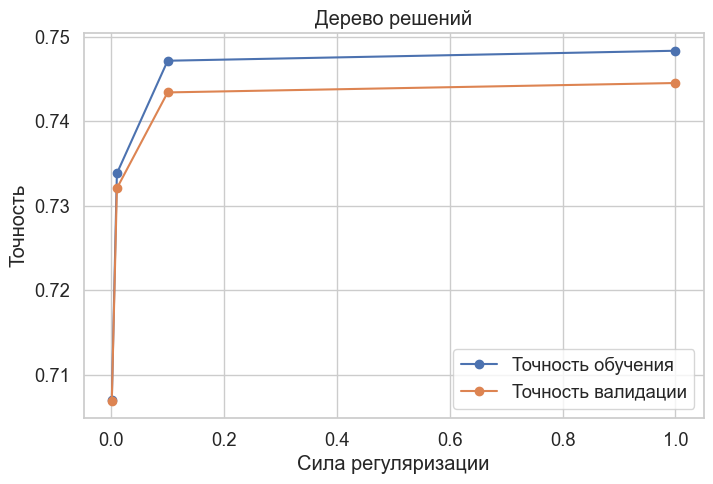

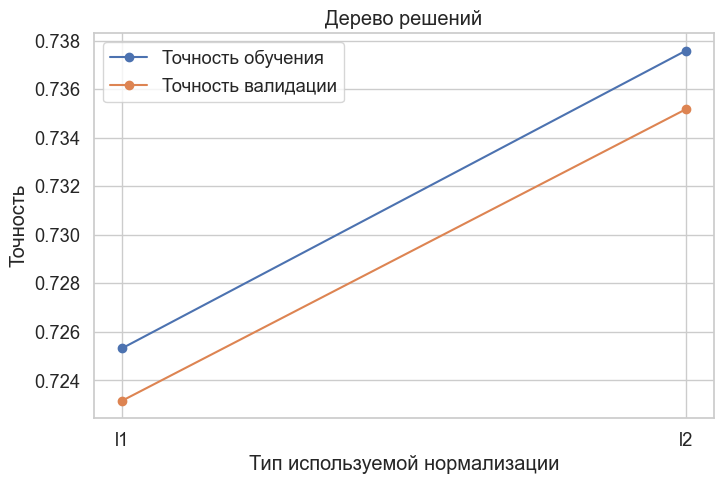

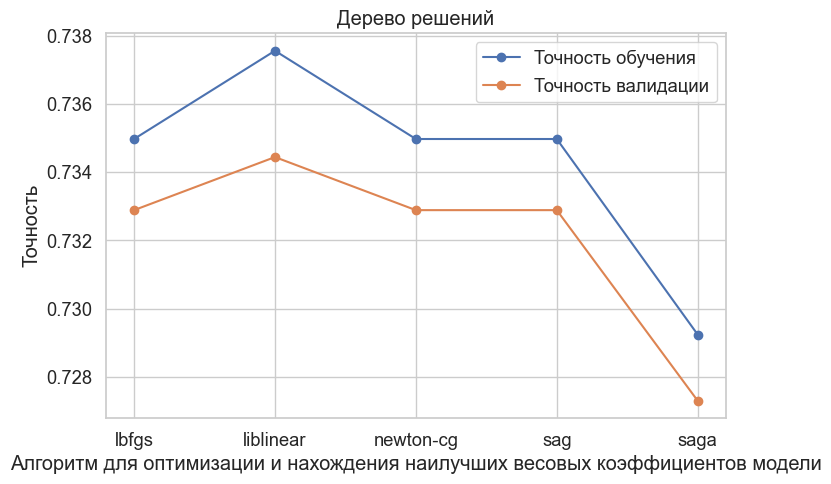

In [24]:
plot_param_vs_accuracy('clf__C', lr_grid_search, lr_parametrs['clf__C'], 'Сила регуляризации')
plot_param_vs_accuracy('clf__penalty', lr_grid_search, lr_parametrs['clf__penalty'], 'Тип используемой нормализации')
plot_param_vs_accuracy('clf__solver', lr_grid_search, lr_parametrs['clf__solver'], 'Алгоритм для оптимизации и нахождения наилучших весовых коэффициентов модели')



Теперь укрупним параметры 'C' в близи 0.01

In [25]:
count = 50
step = int((0.1 - 0.001)/100 * 100000)
start = int(0.001*100000)
stop = int(0.1*100000 + 1)

lst = [i/100000 for i in range(start,stop, step)]


In [26]:
%%time


lr_parametrs = {
    'clf__C': lst,
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

pipe_logreg = Pipeline([
      ('scale', StandardScaler()),
      ('clf', LogisticRegression(random_state=42))
  ])

lr_grid_search = GridSearchCV(pipe_logreg, lr_parametrs, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(x_train, y_train)

print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)

print(f'Лучший score, то есть метрика валидации нашей модели: {lr_grid_search.best_score_:.4f}')

best_model_logistic_reg_grow_up = lr_grid_search.best_estimator_


Best parameters for Logistic Regression: {'clf__C': 0.00496, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Лучший score, то есть метрика валидации нашей модели: 0.7484
CPU times: user 2.24 s, sys: 92.9 ms, total: 2.33 s
Wall time: 3.59 s


<div style="background-color: #e8ccff; padding: 10px; border-radius: 5px;"> 
    Итого Logistic Regression через pipelines и укрупнение параметра C дает нам <strong>0.7484</strong>, что немного ниже необходимых <strong>0.75</strong>
</div>

#### Обучение и оценка Random Forest

Повторим те же операции

Для тюнинга модели будем использовать поиск по сетке - метод GridSearchCV. В качестве перебираемых гиперпараметров будут:
- **n_estimators** - Количество деревьев в лесу. Это число указывает, сколько деревьев решений будет построено в ансамбле случайного леса. Больше деревьев обычно приводит к лучшей производительности модели, но также увеличивает время обучения и требует больше вычислительных ресурсов.
- **max_depth** - Максимальная глубина дерева. Этот параметр ограничивает количество уровней, которые могут быть созданы в каждом дереве решений. Ограничение глубины дерева может помочь предотвратить переобучение, однако слишком низкое значение может привести к недообучению.
- **min_samples_split** -  Минимальное количество объектов, необходимых для разделения внутреннего узла. Если количество объектов в узле меньше этого значения, то узел не будет разделен. Более высокие значения могут предотвратить переобучение, однако слишком высокие значения могут привести к недообучению.
- **min_samples_leaf** - Минимальное количество объектов, которые должны быть в листовом (конечном) узле. Если узел имеет меньше объектов, чем указано в этом параметре, он будет объединен с соседним узлом. Этот параметр помогает контролировать переобучение, но слишком высокие значения могут привести к недообучению.

In [22]:
%%time

rf_parametrs = {
    'rf__n_estimators': [10, 20, 30, 40, 50, 100, 200],
    'rf__max_depth': [3, 5, 7, 9, 11, 13, None],
    'rf__min_samples_split': [2, 4, 6],
    'rf__min_samples_leaf': [1, 2, 4]
}

pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])


rf_grid_search = GridSearchCV(pipe_rf, rf_parametrs, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
rf_grid_search.fit(x_train, y_train)

print("Best parameters for Random Forest:", rf_grid_search.best_params_)

print(f'Лучший score: {rf_grid_search.best_score_:.4f}')

best_model_random_forest_ = rf_grid_search.best_estimator_


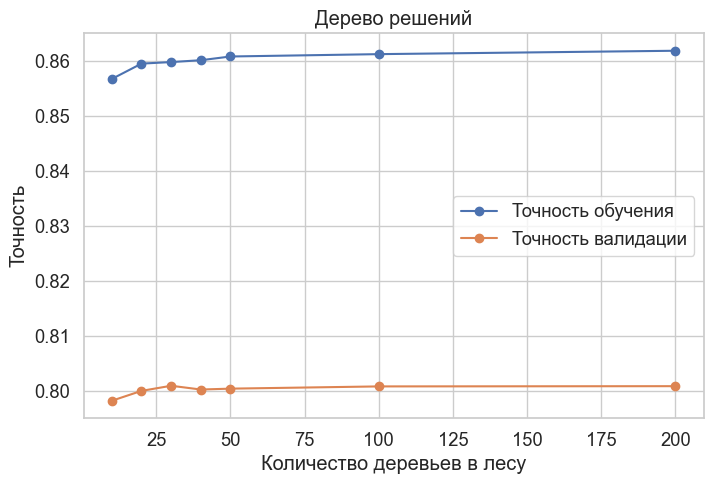

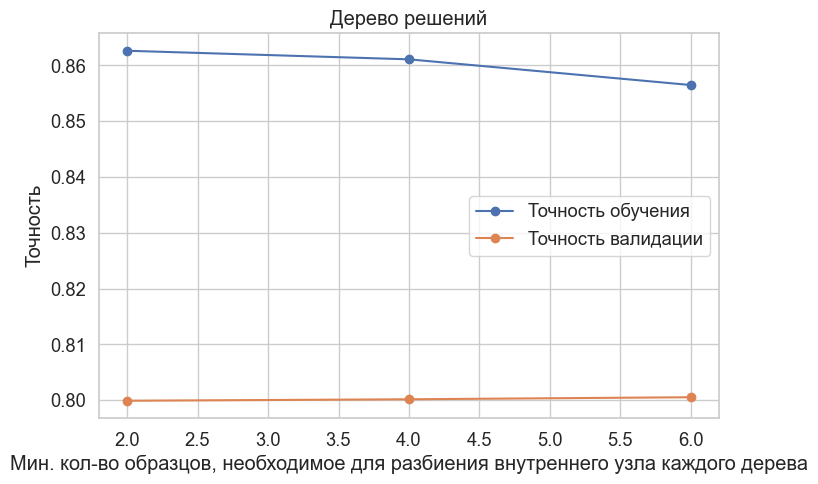

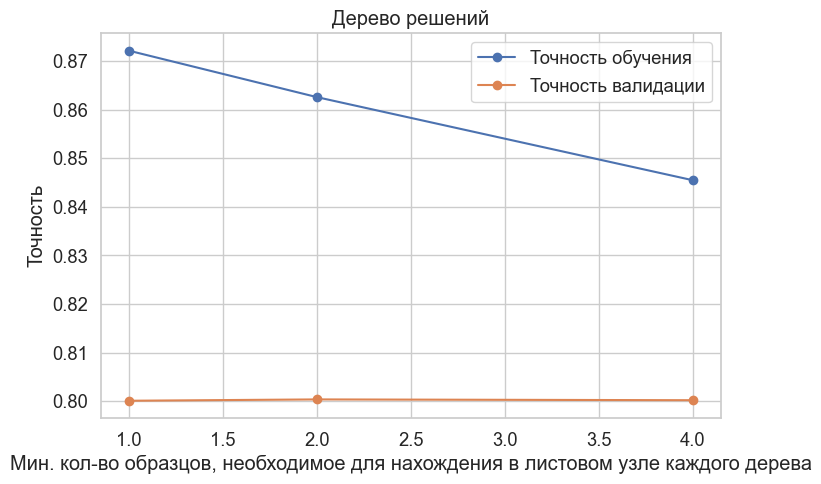

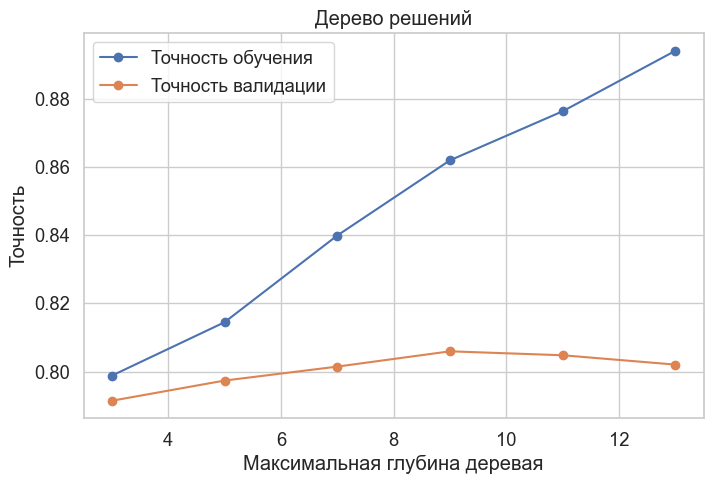

In [23]:
plot_param_vs_accuracy('rf__n_estimators', rf_grid_search, rf_parametrs['rf__n_estimators'], 'Количество деревьев в лесу')
plot_param_vs_accuracy('rf__min_samples_split', rf_grid_search, rf_parametrs['rf__min_samples_split'], 'Мин. кол-во образцов, необходимое для разбиения внутреннего узла каждого дерева')
plot_param_vs_accuracy('rf__min_samples_leaf', rf_grid_search, rf_parametrs['rf__min_samples_leaf'], 'Мин. кол-во образцов, необходимое для нахождения в листовом узле каждого дерева')
plot_param_vs_accuracy('rf__max_depth', rf_grid_search, rf_parametrs['rf__max_depth'], 'Максимальная глубина деревая')


Укрупним гиперпараметры вблизи лучших значений

In [24]:
n_estimators_lst = [i for i in range(10,30, 1)]
max_depth_lst = [8, 9,10,11,12,13]
min_samples_split_lst = [1,2,3,4]
min_samples_leaf_lst = [1,2,3]


In [25]:
%%time


rf_parametrs_enlarged = {
    'rf__n_estimators': n_estimators_lst,
    'rf__max_depth': max_depth_lst,
    'rf__min_samples_split': min_samples_split_lst,
    'rf__min_samples_leaf': min_samples_leaf_lst
}


rf_grid_search = GridSearchCV(pipe_rf, rf_parametrs_enlarged, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(x_train, y_train)

print("Best parameters for Random Forest:", rf_grid_search.best_params_)

print(f'Лучший score: {rf_grid_search.best_score_:.4f}')

best_model_random_forest_enlarged = rf_grid_search.best_estimator_


<div style="background-color: #e8ccff; padding: 10px; border-radius: 5px;"> 
    Итого Random Forest через pipelines и укрупнение параметра n_estimators дает нам <strong>0.8125</strong>, что лучше необходимых <strong>0.75</strong>
</div>

#### Обучение и оценка Decision Tree

- **criterion:** Функция для измерения качества разделения. Варианты gini и entropy соответствуют индексу Джини и энтропии информации соответственно. Индекс Джини измеряет неравномерность выборок, а энтропия информации измеряет уровень неопределенности.
- **max_features:** Количество признаков, которые следует учитывать при поиске лучшего разделения. Варианты auto, sqrt и log2 соответствуют числу признаков, квадратному корню числа признаков и логарифму числа признаков по основанию 2 соответственно. Использование меньшего количества признаков при поиске лучшего разделения может сделать модель более устойчивой к переобучению и ускорить процесс обучения.

In [26]:
%%time

dt_parametrs = {
    'dtc__max_depth': [3, 5, 7, 9, 11, 13, 17, 20,30,40,50,60,70,80,90,100,150,180,200,300,400, None],
    'dtc__min_samples_split': [2, 4, 6, 8, 10],
    'dtc__min_samples_leaf': [1, 2, 4,],
    'dtc__criterion' :['gini', 'entropy'],
    'dtc__max_features': ['auto', 'sqrt', 'log2'],
}


pipe_dt = Pipeline([
    ('scale', StandardScaler()),
    ('dtc', DecisionTreeClassifier(random_state=42))
])


dt_grid_search = GridSearchCV(pipe_dt, dt_parametrs, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
dt_grid_search.fit(x_train, y_train)

print("Best parameters for Decision Tree:", dt_grid_search.best_params_)

print(f'Лучший score: {dt_grid_search.best_score_:.4f}')

best_model_decision_tree_ = dt_grid_search.best_estimator_


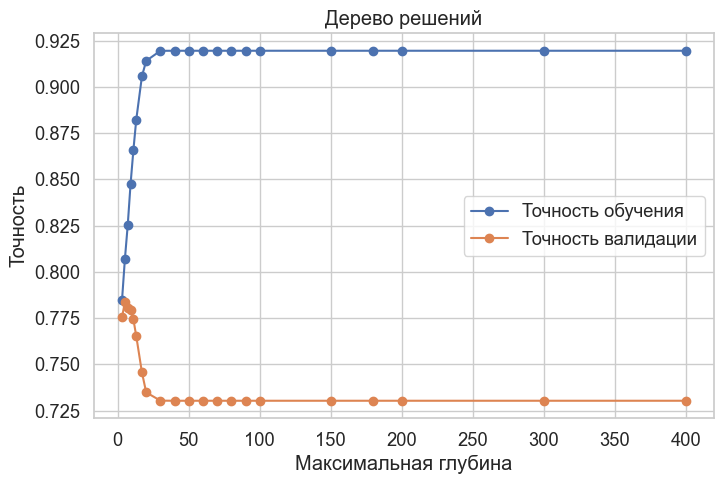

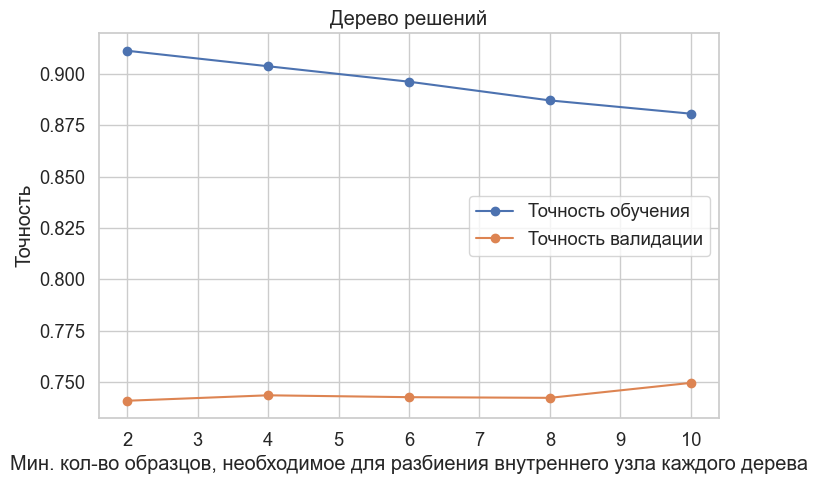

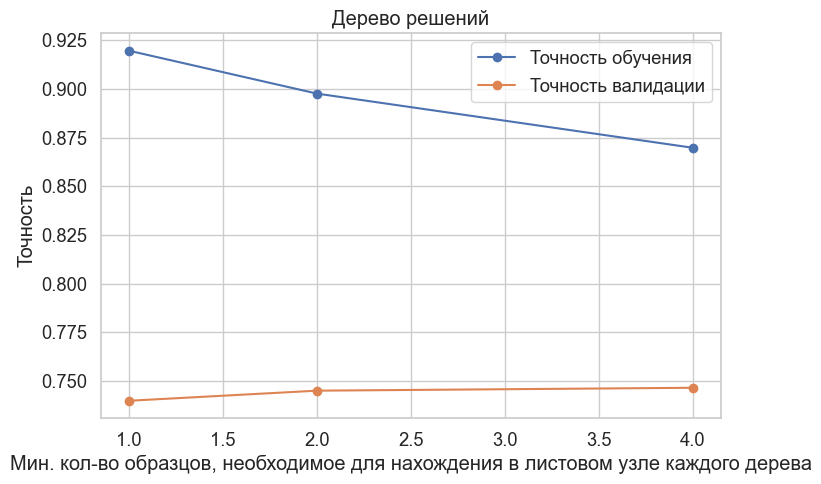

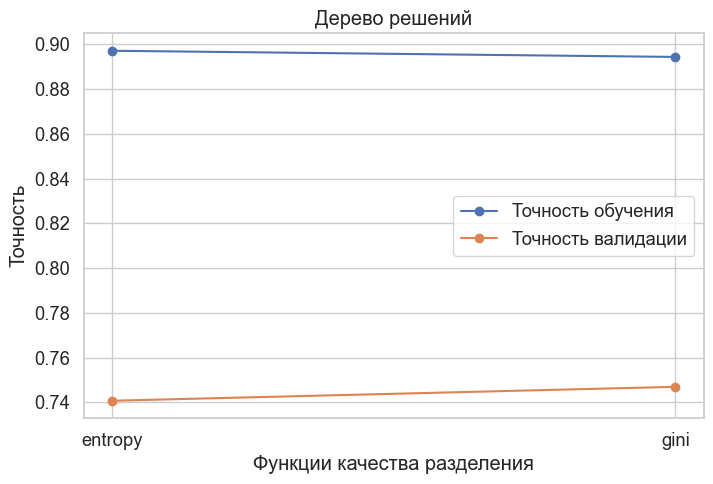

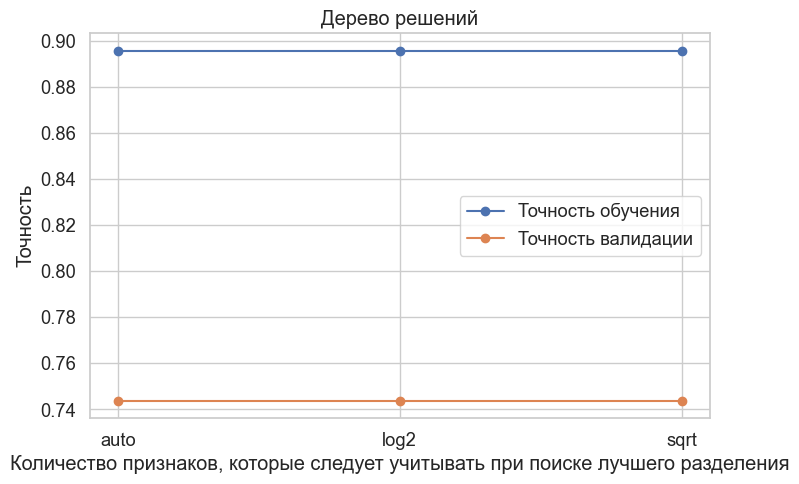

In [27]:
plot_param_vs_accuracy('dtc__max_depth', dt_grid_search, dt_parametrs['dtc__max_depth'], 'Максимальная глубина')
plot_param_vs_accuracy('dtc__min_samples_split', dt_grid_search, dt_parametrs['dtc__min_samples_split'], 'Мин. кол-во образцов, необходимое для разбиения внутреннего узла каждого дерева')
plot_param_vs_accuracy('dtc__min_samples_leaf', dt_grid_search, dt_parametrs['dtc__min_samples_leaf'], 'Мин. кол-во образцов, необходимое для нахождения в листовом узле каждого дерева')
plot_param_vs_accuracy('dtc__criterion', dt_grid_search, dt_parametrs['dtc__criterion'], 'Функции качества разделения')
plot_param_vs_accuracy('dtc__max_features', dt_grid_search, dt_parametrs['dtc__max_features'], 'Количество признаков, которые следует учитывать при поиске лучшего разделения')

Укрупним гиперпараметры вблизи лучших значений

In [28]:
dt_parametrs_enlarged = {
    'dtc__max_depth': [4, 5,6,7,8],
    'dtc__min_samples_split': [7,8,9,10],
    'dtc__min_samples_leaf': [1, 2, 3],
    'dtc__criterion' :['entropy'],
    'dtc__max_features': ['auto'],
}


In [29]:
dt_grid_search = GridSearchCV(pipe_dt, dt_parametrs_enlarged, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(x_train, y_train)

print("Best parameters for Decision Tree:", dt_grid_search.best_params_)
print(f'\nЛучший score: {dt_grid_search.best_score_:.4f}')

best_model_decision_tree_enlarged = dt_grid_search.best_estimator_

<div style="background-color: #e8ccff; padding: 10px; border-radius: 5px;"> 
    Итого Decision Tree через pipelines и укрупнение параметра дает нам <strong>0.7935</strong>, что лучше необходимых <strong>0.75</strong>
</div>

<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
    
1. Переобучение модели. На train, скорее всего, будет продолжать улучшаться или оставаться стабильно высокой, так как модель становится все более сложной и лучше подгоняется под обучающие данные. Это еще один признак переобучения: высокая точность на обучающих данных и снижение точности на валидационных данных. 
2. RF анализирует множетсво решений, как я понял из теории, но вот погуглил и обратился с этим вопросом к chatGPT4 и стало понятно:

    Random Forest (RF) — это ансамблевый метод машинного обучения, который объединяет несколько деревьев решений (Decision Trees, DT) для получения лучшей производительности и устойчивости к переобучению.
- Усреднение прогнозов: Random Forest строит множество деревьев решений и усредняет их прогнозы. Это приводит к снижению дисперсии и более стабильным предсказаниям, поскольку шум от отдельных деревьев уменьшается.
- Уменьшение переобучения: Random Forest вводит случайность в процесс построения деревьев решений с помощью бутстреп-выборок (подмножеств обучающих данных, выбранных с заменой) и случайного подмножества признаков для разделения узлов. Эти случайные изменения уменьшают вероятность переобучения, поскольку каждое дерево в ансамбле строится независимо и на разных подмножествах данных/признаков.
- Более глубокие деревья: В Random Forest обычно строятся более глубокие деревья по сравнению с одиночными деревьями решений. Более глубокие деревья могут выявлять более сложные зависимости между признаками и целевой переменной, что может улучшить производительность модели.

3.  регрессия в названии "логистическая регрессия" отражает историческое и математическое происхождение метода, хотя на практике он используется для решения задач классификации. Это результат развития метода и его применения в разных областях.

Логистическая регрессия является разновидностью обычной линейной регрессии, но с ключевым отличием: она использует логистическую функцию (сигмоиду) для преобразования выхода линейной комбинации признаков в вероятность принадлежности к одному из классов. Это позволяет применять логистическую регрессию для задач классификации, а не для предсказания непрерывных значений, как это делается в обычной линейной регрессии.

В основе логистической регрессии лежит концепция использования линейной модели для предсказания вероятностей принадлежности к классам, а затем использования порогового значения для определения фактического класса объекта. Это позволяет применять логистическую регрессию для задач классификации, хотя сам подход основан на регрессионной модели.
    
4.Логистическая регрессия может показывать худшие результаты по сравнению с другими моделями классификации из-за нескольких причин:

- Линейность: Логистическая регрессия является линейной моделью, что означает, что она хорошо работает, если есть линейная зависимость между признаками и целевой переменной. Однако, если данные имеют сложную структуру или нелинейные зависимости, логистическая регрессия может не справиться с задачей так хорошо, как более сложные модели, такие как деревья решений или случайный лес.
- Выбросы: Логистическая регрессия чувствительна к выбросам в данных, которые могут сильно исказить коэффициенты модели. В то время как другие методы, такие как случайный лес, более устойчивы к выбросам.
- Количественные переменные: Логистическая регрессия предполагает, что зависимость между признаками и целевой переменной логистическая, что может быть не всегда верно для количественных переменных.
- Корреляция между признаками: Логистическая регрессия предполагает, что признаки независимы друг от друга. Если в данных есть мультиколлинеарность (сильная корреляция между признаками), это может привести к неустойчивым оценкам коэффициентов и ухудшению качества модели.
- Разделение классов: В некоторых случаях, когда классы линейно неразделимы, логистическая регрессия может испытывать трудности с обучением хорошей модели. В этом случае, другие методы, такие как SVM с ядрами, могут показать лучшие результаты.

    
   </div>

## Проверьте модель на тестовой выборке

Лучшей моделью стала Random Forest, проверим ее на тестовой выборке


In [30]:
forest_predictions = best_model_random_forest_enlarged.predict(x_test)
score = accuracy_score(y_test, forest_predictions)
print(score)

<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
    
Ради интереса проверил и другие модели на тестовой выборке и подтердил, что они хуже, чем Random Forest. (0.742 и 0.788)    
   </div>

<div style="background-color: #e8ccff; padding: 10px; border-radius: 5px;"> 
В итоге мы получаем точность 0.8211%, что явяется неплохим результатом </div>

<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
    
Модель может помочь, например, команде продаж нацелиться на клиентов, которые вероятно будут заинтересованы в конкретном тарифе, что увеличит эффективность продаж и снизит затраты на взаимодействие с клиентом, потому что благодаря модели поведение клиента будет проанализировано быстрее и модель выдаст рекомендацию по тарифу.

</div>

In [31]:
y_pred = best_model_random_forest_enlarged.predict(x_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion matrix:")
print(conf_matrix)


## (бонус) Проверьте модели на адекватность

Для проверки модель на адекватность посмотрим на распределение классов в нашей выборке:

Для проверки модели на адекватность будем использовать класс DummyClassifier и сравним полученный результат с работой реальной модели

In [32]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)

dummy_pred = dummy_clf.predict(x_test)
dummy_accuracy = accuracy_score(y_test, dummy_pred)

print("Точность наиболее часто встречающегося класса: {:.4f}".format(dummy_accuracy))

Мы получаем значение accuracy 0.6935, а значение нашей модели Decision Tree -  0.8211. Это значит, что наша модель работает и мы выдаем прогноз лучше.